In [117]:
import numpy as np
import copy
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
np.set_printoptions(linewidth=10000, threshold=10000)

In [168]:
def theoretical_prob(initial, step, ptran, nq):
        Pi_op = Pi_operator(ptran)
        swap = swap_operator(nq)
        operator = (2*Pi_op) - np.identity(len(Pi_op))
        Szegedy = np.dot(operator, swap)
        Szegedy_n = copy.copy(Szegedy)
        print(id(Szegedy), id(Szegedy_n))
        if step == 0:
            init_prob = np.array([abs(i)**2 for i in initial], dtype=np.float)
            return init_prob
        elif step == 1:
            prob = np.array([abs(i)**2 for i in np.dot(Szegedy, initial)],
                            dtype=np.float)
            return prob
        else:
            for n in range(step-1):
                Szegedy_n = np.dot(Szegedy_n, Szegedy)
            probs = np.array([abs(i)**2 for i in np.dot(initial, Szegedy_n)],
                             dtype=np.float)
            return probs

def swap_operator(n_qubit):
    q1 = QuantumRegister(n_qubit//2)
    q2 = QuantumRegister(n_qubit//2)
    qc = QuantumCircuit(q1, q2)
    for c, t in zip(q1, q2):
        qc.swap(c, t)
    # FIXME
    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend=backend)
    swap = job.result().get_unitary(qc)
    return swap

def Pi_operator(ptran):
    '''
    This is not a quantum operation,
    just returning matrix
    '''
    lg = len(ptran)
    psi_op = []
    count = 0
    for i in range(lg):
        psi_vec = [0 for _ in range(lg**2)]
        for j in range(lg):
            psi_vec[count] = np.sqrt(ptran[j][i])
            count += 1
        psi_op.append(np.kron(np.array(psi_vec).T,
                      np.conjugate(psi_vec)).reshape((lg**2, lg**2)))
    Pi = psi_op[0]
    for i in psi_op[1:]:
        Pi = np.add(Pi, i)
    return Pi

def is_unitary(operator, tolerance=0.0001):
    h, w = operator.shape
    if not h == w:
        return False
    adjoint = np.conjugate(operator.transpose())
    product1 = np.dot(operator, adjoint)
    product2 = np.dot(adjoint, operator)
    ida = np.eye(h)
    return np.allclose(product1, ida) & np.allclose(product2, ida)


In [169]:
alpha = 0.85
target_graph = np.array([[0, 1, 0, 0, 0, 0, 0, 1],
                                [0, 0, 1, 0, 0, 0, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0],
                                [0, 0, 0, 1, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0, 1, 0],
                                [0, 0, 0, 0, 0, 1, 0, 1],
                                [0, 0, 0, 0, 0, 0, 1, 0]])

E = np.array([[1/8, 1/2, 0, 0, 0, 0, 0, 1/2],
                [1/8, 0, 1/2, 0, 0, 0, 0, 0],
                [1/8, 1/2, 0, 1/2, 0, 0, 0, 0],
                [1/8, 0, 1/2, 0, 1/2, 0, 0, 0],
                [1/8, 0, 0, 1/2, 0, 1/2, 0, 0],
                [1/8, 0, 0, 0, 1/2, 0, 1/2, 0],
                [1/8, 0, 0, 0, 0, 1/2, 0, 1/2],
                [1/8, 0, 0, 0, 0, 0, 1/2, 0]])
# use google matrix
lt = len(target_graph)
prob_dist = alpha*E + ((1-alpha)/lt)*np.ones((lt, lt))
init_state_eight = 1/2*np.array([np.sqrt(prob_dist[j][i]) for i in range(lt) for j in range(lt)])

In [170]:
Pi_op = Pi_operator(prob_dist)
operator = (2*Pi_op) - np.identity(len(Pi_op))

In [171]:
lo = len(operator)
initial = np.array([0 if i != 32 else 1 for i in range(lo)])
# initial = np.array([np.sqrt(1/lo) for i in range(lo)])

In [172]:
ideal = theoretical_prob(initial, 2, prob_dist, 6)
for i, v in enumerate(ideal):
    print(i, v)

5128882736 5131679664
0 0.05790039062500003
1 4.6801757812500036e-05
2 1.977539062500003e-06
3 0.0011076416015625003
4 1.977539062500003e-06
5 0.0011076416015625003
6 1.977539062500003e-06
7 4.6801757812500036e-05
8 0.05790039062500003
9 1.977539062500003e-06
10 4.6801757812500036e-05
11 0.0011076416015625003
12 1.977539062500003e-06
13 0.0011076416015625003
14 1.977539062500003e-06
15 1.977539062500003e-06
16 0.05790039062500003
17 4.6801757812500036e-05
18 1.977539062500003e-06
19 0.0262141845703125
20 1.977539062500003e-06
21 0.0011076416015625003
22 1.977539062500003e-06
23 1.977539062500003e-06
24 0.05790039062500003
25 1.977539062500003e-06
26 4.6801757812500036e-05
27 0.0011076416015625003
28 4.6801757812500036e-05
29 0.0011076416015625003
30 1.977539062500003e-06
31 1.977539062500003e-06
32 0.521103515625
33 0.001302758789062501
34 0.001302758789062501
35 0.0004212158203125004
36 0.001302758789062501
37 0.0004212158203125004
38 0.001302758789062501
39 0.001302758789062501
40 0.

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

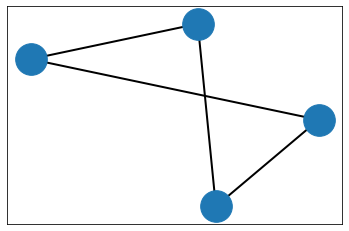

In [12]:
target_graph = np.array([[0, 1, 0, 1],
                                [0, 0, 1, 0],
                                [0, 1, 0, 1],
                                [0, 0, 1, 0]])
G = nx.from_numpy_matrix(target_graph)
pos = nx.layout.spring_layout(G)
nodes = nx.draw_networkx_nodes(G, pos, node_size=1000)
edges = nx.draw_networkx_edges(G, pos, node_size=1000, arrowstyle='->',
                               arrowsize=10, edge_cmap=plt.cm.Blues, width=2)

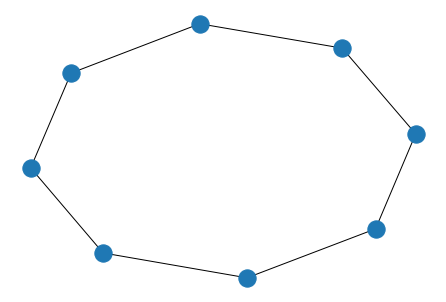

In [14]:
target_graph = np.array([[0, 1, 0, 0, 0, 0, 0, 1],
                                [0, 0, 1, 0, 0, 0, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0],
                                [0, 0, 0, 1, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0, 1, 0],
                                [0, 0, 0, 0, 0, 1, 0, 1],
                                [0, 0, 0, 0, 0, 0, 1, 0]])
G = nx.from_numpy_matrix(target_graph)
nx.draw(G)